In [1]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

In [45]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import extinction as extinction

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,feh,am,distance,isochrones):
        
        '''
        feh: [float] metallicity of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.salfeh = feh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # PARSEC isochrones
        self.jlabel = 'Jmag'
        self.hlabel = 'Hmag'
        self.klabel = 'Ksmag'
        self.rplabel = 'G_RPmag'
        self.glabel = 'Gmag'
        self.bplabel = 'G_BPmag'
        self.uniq_ages = 10**np.unique(isochrones['logAge'])/10**9
        self.iso = isochrones
        
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
        return close1,close2
    
    def wang_alav(self,wave):
        '''
        Calculate the relative extinction to Av accoding to Wang et al. 2019
    
        Input:
        -----
            wave: effective wavelength in microns of the passband
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x = 1/wave 
        if 0.3 <= x < 1.0:
            y = x - 1.82
            alav = (1.0+0.7499*y-0.1086*(y**2)-0.08909*(y**3)+0.02905*(y**4)+
                    0.01069*(y**5)+0.001707*(y**6)-0.001002*(y**7))
            return alav
    
        elif 1.0 <= x < 3.33:
            #0.3722 +/- 0.0026; -2.070 +/- 0.030
            alav = 0.3722*(wave**-2.070)
            return alav
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: extinction in the same band used to initialize the class
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        lgteff = np.log10(teff)
        
        ajak = self.wang_alav(self.leff['J'])/self.wang_alav(self.leff['K'])
        ahak = self.wang_alav(self.leff['H'])/self.wang_alav(self.leff['K'])
        abpak = self.wang_alav(self.leff['BP'])/self.wang_alav(self.leff['K'])
        agak = self.wang_alav(self.leff['G'])/self.wang_alav(self.leff['K'])
        arpak = self.wang_alav(self.leff['RP'])/self.wang_alav(self.leff['K'])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if age in self.uniq_ages:
            
            print('in: ',age)
            
            # pick out a single isochrone 
            iso_ = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],np.log10(age*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            
            sj = iso_[self.jlabel][sidx]
            sh = iso_[self.hlabel][sidx]
            sk = iso_[self.klabel][sidx]
            sbp = iso_[self.bplabel][sidx]
            sg = iso_[self.glabel][sidx]
            srp = iso_[self.rplabel][sidx]
            
            # splines for each apparent magnitude as function of teff
            _, uidx = np.unique(slogTe,return_index=True)
            
            j_spl = InterpolatedUnivariateSpline(slogTe[uidx],sj[uidx])
            h_spl = InterpolatedUnivariateSpline(slogTe[uidx],sh[uidx])
            k_spl = InterpolatedUnivariateSpline(slogTe[uidx],sk[uidx])
            bp_spl = InterpolatedUnivariateSpline(slogTe[uidx],sbp[uidx])
            g_spl = InterpolatedUnivariateSpline(slogTe[uidx],sg[uidx])
            rp_spl = InterpolatedUnivariateSpline(slogTe[uidx],srp[uidx])
            
            
            j_app = j_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak
            bp_app = bp_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*abpak
            g_app = g_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*agak
            rp_app = rp_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*arpak
            
            print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
            print('Calculated Apparent BP: {:.3f} G: {:.3f} RP: {:.3f}'.format(bp_app,g_app,rp_app))
            print('ak: {:.3f}'.format(ak))
            print('---')
            
            return bp_app,g_app,rp_app,j_app,h_app,k_app
            
        else:
            age_lo,age_hi = self.neighbors(self.uniq_ages,age)
            
            print('age: ',age)
            
            ### age_lo ###
            # pick out a single isochrone 
            iso_lo = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_lo*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            
            sj_lo = iso_lo[self.jlabel][sidx_lo]
            sh_lo = iso_lo[self.hlabel][sidx_lo]
            sk_lo = iso_lo[self.klabel][sidx_lo]
            sbp_lo = iso_lo[self.bplabel][sidx_lo]
            sg_lo = iso_lo[self.glabel][sidx_lo]
            srp_lo = iso_lo[self.rplabel][sidx_lo]
            
            # splines for each magnitude
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            
            j_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sj_lo[uidx_lo])
            h_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sh_lo[uidx_lo])
            k_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sk_lo[uidx_lo])
            bp_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sbp_lo[uidx_lo])
            g_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sg_lo[uidx_lo])
            rp_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],srp_lo[uidx_lo])
            
            ### age_hi ####
            # pick out a single isochrone 
            iso_hi = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_hi*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            
            sj_hi = iso_hi[self.jlabel][sidx_hi]
            sh_hi = iso_hi[self.hlabel][sidx_hi]
            sk_hi = iso_hi[self.klabel][sidx_hi]
            sbp_hi = iso_hi[self.bplabel][sidx_hi]
            sg_hi = iso_hi[self.glabel][sidx_hi]
            srp_hi = iso_hi[self.rplabel][sidx_hi]
            
            # splines for each magnitude as function of log(teff)
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            
            j_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sj_hi[uidx_hi])
            h_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sh_hi[uidx_hi])
            k_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sk_hi[uidx_hi])
            bp_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sbp_hi[uidx_hi])
            g_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sg_hi[uidx_hi])
            rp_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],srp_hi[uidx_hi])
            
            ### Interpolate Between hi and lo ###
            j_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[j_spl_lo(lgteff),j_spl_hi(lgteff)],1))
            h_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[h_spl_lo(lgteff),h_spl_hi(lgteff)],1))
            k_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[k_spl_lo(lgteff),k_spl_hi(lgteff)],1))
            bp_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[bp_spl_lo(lgteff),bp_spl_hi(lgteff)],1))
            g_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[g_spl_lo(lgteff),g_spl_hi(lgteff)],1))
            rp_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[rp_spl_lo(lgteff),rp_spl_hi(lgteff)],1))
            
            # Calculate the theoretical apparent magnitude
            j_app = j_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak
            bp_app = bp_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*abpak
            g_app = g_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*agak
            rp_app = rp_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*arpak
            
            print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
            print('Calculated Apparent BP: {:.3f} G: {:.3f} RP: {:.3f}'.format(bp_app,g_app,rp_app))
            print('ak: {:.3f}'.format(ak))
            print('---')
            
            return bp_app,g_app,rp_app,j_app,h_app,k_app
        
    def Teff2AppMagsAkAg(self,teff,age,ak,ag):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: extinction in the K band
            ag: exrtinction in the G band
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        lgteff = np.log10(teff)
        
        ajak = self.wang_alav(self.leff['J'])/self.wang_alav(self.leff['K'])
        ahak = self.wang_alav(self.leff['H'])/self.wang_alav(self.leff['K']) 
        abpag = self.wang_alav(self.leff['BP'])/self.wang_alav(self.leff['G'])
        arpag = self.wang_alav(self.leff['RP'])/self.wang_alav(self.leff['G'])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if age in self.uniq_ages:
            
            print('in: ',age)
            
            # pick out a single isochrone 
            iso_ = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],np.log10(age*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            
            sj = iso_[self.jlabel][sidx]
            sh = iso_[self.hlabel][sidx]
            sk = iso_[self.klabel][sidx]
            sbp = iso_[self.bplabel][sidx]
            sg = iso_[self.glabel][sidx]
            srp = iso_[self.rplabel][sidx]
            
            # splines for each apparent magnitude as function of teff
            _, uidx = np.unique(slogTe,return_index=True)
            
            j_spl = InterpolatedUnivariateSpline(slogTe[uidx],sj[uidx])
            h_spl = InterpolatedUnivariateSpline(slogTe[uidx],sh[uidx])
            k_spl = InterpolatedUnivariateSpline(slogTe[uidx],sk[uidx])
            bp_spl = InterpolatedUnivariateSpline(slogTe[uidx],sbp[uidx])
            g_spl = InterpolatedUnivariateSpline(slogTe[uidx],sg[uidx])
            rp_spl = InterpolatedUnivariateSpline(slogTe[uidx],srp[uidx])
            
            
            j_app = j_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak
            bp_app = bp_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ag*abpag
            g_app = g_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ag
            rp_app = rp_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ag*arpag
            
            print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
            print('ak: {:.3f}'.format(ak))
            print('Calculated Apparent BP: {:.3f} G: {:.3f} RP: {:.3f}'.format(bp_app,g_app,rp_app))
            print('ag: {:.3f}'.format(ag))
            print('---')
            
            return bp_app,g_app,rp_app,j_app,h_app,k_app
            
        else:
            age_lo,age_hi = self.neighbors(self.uniq_ages,age)
            
            print('age: ',age)
            
            ### age_lo ###
            # pick out a single isochrone 
            iso_lo = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_lo*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            
            sj_lo = iso_lo[self.jlabel][sidx_lo]
            sh_lo = iso_lo[self.hlabel][sidx_lo]
            sk_lo = iso_lo[self.klabel][sidx_lo]
            sbp_lo = iso_lo[self.bplabel][sidx_lo]
            sg_lo = iso_lo[self.glabel][sidx_lo]
            srp_lo = iso_lo[self.rplabel][sidx_lo]
            
            # splines for each magnitude
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            
            j_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sj_lo[uidx_lo])
            h_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sh_lo[uidx_lo])
            k_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sk_lo[uidx_lo])
            bp_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sbp_lo[uidx_lo])
            g_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sg_lo[uidx_lo])
            rp_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],srp_lo[uidx_lo])
            
            ### age_hi ####
            # pick out a single isochrone 
            iso_hi = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_hi*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            
            sj_hi = iso_hi[self.jlabel][sidx_hi]
            sh_hi = iso_hi[self.hlabel][sidx_hi]
            sk_hi = iso_hi[self.klabel][sidx_hi]
            sbp_hi = iso_hi[self.bplabel][sidx_hi]
            sg_hi = iso_hi[self.glabel][sidx_hi]
            srp_hi = iso_hi[self.rplabel][sidx_hi]
            
            # splines for each magnitude as function of log(teff)
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            
            j_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sj_hi[uidx_hi])
            h_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sh_hi[uidx_hi])
            k_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sk_hi[uidx_hi])
            bp_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sbp_hi[uidx_hi])
            g_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sg_hi[uidx_hi])
            rp_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],srp_hi[uidx_hi])
            
            ### Interpolate Between hi and lo ###
            j_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[j_spl_lo(lgteff),j_spl_hi(lgteff)],1))
            h_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[h_spl_lo(lgteff),h_spl_hi(lgteff)],1))
            k_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[k_spl_lo(lgteff),k_spl_hi(lgteff)],1))
            bp_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[bp_spl_lo(lgteff),bp_spl_hi(lgteff)],1))
            g_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[g_spl_lo(lgteff),g_spl_hi(lgteff)],1))
            rp_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[rp_spl_lo(lgteff),rp_spl_hi(lgteff)],1))
            
            # Calculate the theoretical apparent magnitude
            j_app = j_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ajak
            h_app = h_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ahak
            k_app = k_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak
            bp_app = bp_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ag*abpag
            g_app = g_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ag
            rp_app = rp_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ag*arpag
            
            print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
            print('ak: {:.3f}'.format(ak))
            print('Calculated Apparent BP: {:.3f} G: {:.3f} RP: {:.3f}'.format(bp_app,g_app,rp_app))
            print('ag: {:.3f}'.format(ag))
            print('---')
            
            return bp_app,g_app,rp_app,j_app,h_app,k_app

# Parsec

In [5]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

In [6]:
massive.columns

ColDefs(
    name = 'Zini'; format = 'D'
    name = 'MH'; format = 'D'
    name = 'logAge'; format = 'D'
    name = 'Mini'; format = 'D'
    name = 'int_IMF'; format = 'D'
    name = 'Mass'; format = 'D'
    name = 'logL'; format = 'D'
    name = 'logTe'; format = 'D'
    name = 'logg'; format = 'D'
    name = 'label'; format = 'K'
    name = 'McoreTP'; format = 'D'
    name = 'C_O'; format = 'D'
    name = 'period0'; format = 'D'
    name = 'period1'; format = 'D'
    name = 'period2'; format = 'D'
    name = 'period3'; format = 'D'
    name = 'period4'; format = 'D'
    name = 'pmode'; format = 'K'
    name = 'Mloss'; format = 'D'
    name = 'tau1m'; format = 'D'
    name = 'X'; format = 'D'
    name = 'Y'; format = 'D'
    name = 'Xc'; format = 'D'
    name = 'Xn'; format = 'D'
    name = 'Xo'; format = 'D'
    name = 'Cexcess'; format = 'D'
    name = 'Z'; format = 'D'
    name = 'mbolmag'; format = 'D'
    name = 'Gmag'; format = 'D'
    name = 'G_BPmag'; format = 'D'
    name = '

In [25]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def wang_alav(wave):
    '''
    Calculate the relative extinction to Av accoding to Wang et al. 2019
    
    Input:
    -----
        wave: effective wavelength in microns of the passband
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x = 1/wave 
    if 0.3 <= wave < 1.0:
        y = x - 1.82
        alav = (1.0+0.7499*y-0.1086*(y**2)-0.08909*(y**3)+0.02905*(y**4)+
                0.01069*(y**5)+0.001707*(y**6)-0.001002*(y**7))
        return alav
    
    elif 1.0 <= wave < 3.33:
        #0.3722 +/- 0.0026; -2.070 +/- 0.030
        alav = 0.3722*(wave**-2.070)
        return alav

In [42]:
print(wang_alav(leff['BP']))
print(wang_alav(leff['G']))
print(wang_alav(leff['RP']))

1.0270894646873612
0.7976997639837907
0.5983129921576779


# Globular Clusters

In [8]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [10]:
print(gcs.columns)

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

# Test Code

In [11]:
from scipy.optimize import curve_fit

In [54]:
# pick star
g_idx = 1024

# initialize class
CalcAge = WhatsMyAgeAgain(gcs['M_H'][g_idx],gcs['ALPHA_M'][g_idx],10400,massive)

# curve_fit does its thing
popt, pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][g_idx],
                         np.array([[gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx],
                                    gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx],gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx],
                                    gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]]],dtype=float).T.ravel(),
                         p0=[10.,gcs['AK_TARG'][g_idx]],bounds=((0.,0.),(14.,1.)),method='dogbox')#


print('Measured Apparent J: {:3f} H: {:.3f} K: {:.3f}'.format(gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]))
print('Measured Apparent BP: {:3f} G: {:.3f} RP: {:.3f}'.format(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx],
                                                                gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx],
                                                                gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]))
print('Measured Ak: {:.3f}'.format(gcs['AK_TARG'][g_idx]))
print('Final Calculated [Age, Ak]:',popt)

in:  10.0
Calculated Apparent J: 12.347 H: 11.765 K: 11.676
Calculated Apparent BP: 14.492 G: 13.938 RP: 13.248
ak: 0.004
---
age:  10.000000149011612
Calculated Apparent J: 12.347 H: 11.765 K: 11.676
Calculated Apparent BP: 14.492 G: 13.938 RP: 13.248
ak: 0.004
---
in:  10.0
Calculated Apparent J: 12.347 H: 11.765 K: 11.676
Calculated Apparent BP: 14.492 G: 13.938 RP: 13.248
ak: 0.004
---
age:  9.999997684670857
Calculated Apparent J: 12.334 H: 11.758 K: 11.672
Calculated Apparent BP: 14.424 G: 13.890 RP: 13.215
ak: 0.000
---
age:  9.999997833682436
Calculated Apparent J: 12.334 H: 11.758 K: 11.672
Calculated Apparent BP: 14.424 G: 13.890 RP: 13.215
ak: 0.000
---
age:  9.999997684670857
Calculated Apparent J: 12.334 H: 11.758 K: 11.672
Calculated Apparent BP: 14.424 G: 13.890 RP: 13.215
ak: 0.000
---
age:  5.593689118151756
Calculated Apparent J: 12.062 H: 11.488 K: 11.402
Calculated Apparent BP: 14.155 G: 13.619 RP: 12.943
ak: 0.000
---
age:  5.59368920150422
Calculated Apparent J: 1

In [53]:
# pick star
g_idx = 1024

# initialize class
CalcAge = WhatsMyAgeAgain(gcs['M_H'][g_idx],gcs['ALPHA_M'][g_idx],10400,massive)

# curve_fit does its thing
popt, pcov = curve_fit(CalcAge.Teff2AppMagsAkAg,gcs['TEFF'][g_idx],
                       np.array([[gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx],
                                  gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx],gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx],
                                  gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]]],dtype=float).T.ravel(),
                       p0=[10.,gcs['AK_TARG'][g_idx],gcs['GAIA_A_G_VAL'][g_idx]],bounds=((0.,0.,0.1),(14.,1.,1.)),
                       method='dogbox')


print('Measured Apparent J: {:3f} H: {:.3f} K: {:.3f}'.format(gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]))
print('Measured Ak: {:.3f}'.format(gcs['AK_TARG'][g_idx]))

print('Measured Apparent BP: {:3f} G: {:.3f} RP: {:.3f}'.format(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx],
                                                                gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx],
                                                                gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]))
print('Measured Ag: {:.3f}'.format(gcs['GAIA_A_G_VAL'][g_idx]))
print('Final Calculated [Age, Ak, Ag]:',popt)

in:  10.0
Calculated Apparent J: 12.347 H: 11.765 K: 11.676
ak: 0.004
Calculated Apparent BP: 14.700 G: 14.082 RP: 13.348
ag: 0.192
---
age:  10.000000149011612
Calculated Apparent J: 12.347 H: 11.765 K: 11.676
ak: 0.004
Calculated Apparent BP: 14.700 G: 14.082 RP: 13.348
ag: 0.192
---
in:  10.0
Calculated Apparent J: 12.347 H: 11.765 K: 11.676
ak: 0.004
Calculated Apparent BP: 14.700 G: 14.082 RP: 13.348
ag: 0.192
---
in:  10.0
Calculated Apparent J: 12.347 H: 11.765 K: 11.676
ak: 0.004
Calculated Apparent BP: 14.700 G: 14.082 RP: 13.348
ag: 0.192
---
age:  9.999181519642134
Calculated Apparent J: 12.837 H: 12.035 K: 11.820
ak: 0.148
Calculated Apparent BP: 14.567 G: 13.990 RP: 13.284
ag: 0.100
---
age:  9.99918166864155
Calculated Apparent J: 12.837 H: 12.035 K: 11.820
ak: 0.148
Calculated Apparent BP: 14.567 G: 13.990 RP: 13.284
ag: 0.100
---
age:  9.999181519642134
Calculated Apparent J: 12.837 H: 12.035 K: 11.820
ak: 0.148
Calculated Apparent BP: 14.567 G: 13.990 RP: 13.284
ag: 0.

Calculated Apparent J: 14.745 H: 12.644 K: 11.688
ak: 1.000
Calculated Apparent BP: 13.591 G: 13.009 RP: 12.302
ag: 0.100
---
age:  1.4000616623564335
Calculated Apparent J: 14.745 H: 12.644 K: 11.688
ak: 1.000
Calculated Apparent BP: 13.591 G: 13.009 RP: 12.302
ag: 0.100
---
age:  1.4000616623564335
Calculated Apparent J: 14.745 H: 12.644 K: 11.688
ak: 1.000
Calculated Apparent BP: 13.591 G: 13.009 RP: 12.302
ag: 0.100
---
age:  1.3995683434018664
Calculated Apparent J: 14.745 H: 12.644 K: 11.689
ak: 1.000
Calculated Apparent BP: 13.591 G: 13.009 RP: 12.302
ag: 0.100
---
age:  1.3999383326177917
Calculated Apparent J: 14.745 H: 12.644 K: 11.688
ak: 1.000
Calculated Apparent BP: 13.591 G: 13.009 RP: 12.302
ag: 0.100
---
age:  1.400030829921773
Calculated Apparent J: 14.745 H: 12.644 K: 11.688
ak: 1.000
Calculated Apparent BP: 13.591 G: 13.009 RP: 12.302
ag: 0.100
---
age:  1.4000308507838581
Calculated Apparent J: 14.745 H: 12.644 K: 11.688
ak: 1.000
Calculated Apparent BP: 13.591 G: 1

In [51]:
gcs['GAIA_A_G_VAL'][1024]

0.192

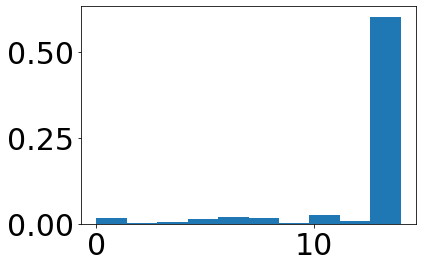

14.0


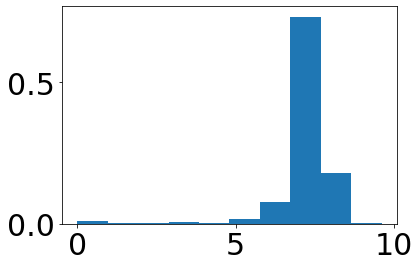

In [45]:
plt.hist(ages,density=True)
plt.show()
print(np.median(ages))

plt.hist(exts,density=True)
plt.show()

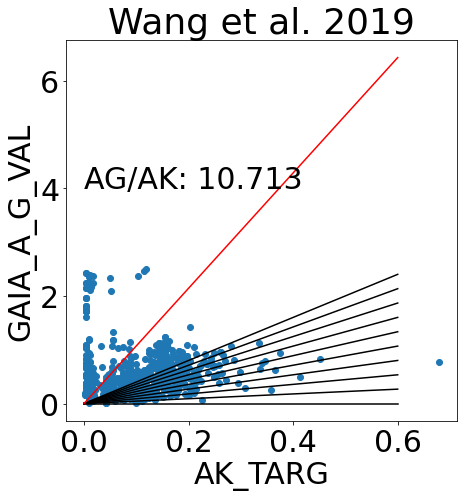

In [57]:
exts = np.where((gcs['AK_TARG']>=0)&(gcs['GAIA_A_G_VAL']>=0))

plt.figure(figsize=[7,7])
plt.scatter(gcs['AK_TARG'][exts],gcs['GAIA_A_G_VAL'][exts])
for i in range(len(np.linspace(0.0,4.0,10))):
    plt.plot(np.array([0.,0.6]),np.array([0.,0.6])*np.linspace(0.0,4.0,10)[i],c='k')
    
plt.plot(np.array([0.,0.6]),np.array([0.,0.6])*wang_alav(leff['G'])/wang_alav(leff['K']),c='r')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'GAIA_A_G_VAL')
plt.title(r'Wang et al. 2019')
plt.text(0.0,4.0,r'AG/AK: {:.3f}'.format(wang_alav(leff['G'])/wang_alav(leff['K'])))
plt.savefig('wangext.pdf',bbox_inches='tight')

In [34]:
def car_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value 
    '''
        
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
             0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a
            
def car_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
        
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
             0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
            
def car_alak(wave):
    '''
    Calculate the relative extinction with the K band as the fiducial band and
    Rv (=Av/E(B_V)) = 3.1
        
    Input:
    -----
        wave: effective wavelength of band in microns
        
    Output:
    ------
        alak: extinction relative to the K band
    '''
        
    x=1/wave
    alak = (3.1*car_a(x)+car_b(x))/(3.1*car_a(1/2.1757)+car_b(1/2.1757))
        
    return alak

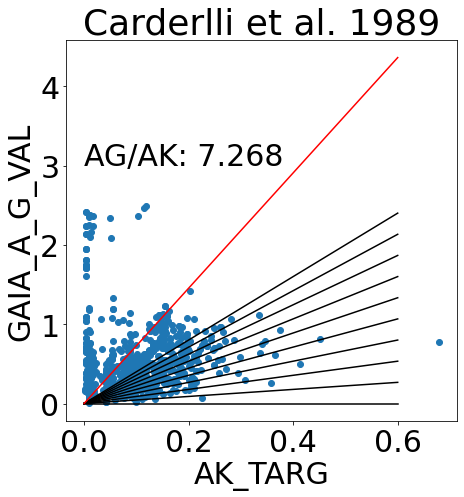

In [56]:
plt.figure(figsize=[7,7])
plt.scatter(gcs['AK_TARG'][exts],gcs['GAIA_A_G_VAL'][exts])
for i in range(len(np.linspace(0.0,4.0,10))):
    plt.plot(np.array([0.,0.6]),np.array([0.,0.6])*np.linspace(0.0,4.0,10)[i],c='k')
    
plt.plot(np.array([0.,0.6]),np.array([0.,0.6])*car_alak(leff['G']),c='r')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'GAIA_A_G_VAL')
plt.title(r'Carderlli et al. 1989')
plt.text(0.0,3.0,r'AG/AK: {:.3f}'.format(car_alak(leff['G'])))
plt.savefig('carext.pdf',bbox_inches='tight')

In [40]:
def ind_alak(wave):
    '''
    Calculate the relative extinction to Ak using Indebetouw et al. 2005.
    This uses GLIMPSE data and has only been verified in IR.
    
    Input:
    -----
        wave: effective wavelength in microns of the passband
        
    Output:
    ------
        alak: A\lambda/Ak
    '''
    # 0.61 +/- 0.04; -2.22 +/- 0.17; 1.21 +/- 0.23
    alak = 10**(0.61-2.22*np.log10(wave)+1.21*(np.log10(wave)**2))
    return alak

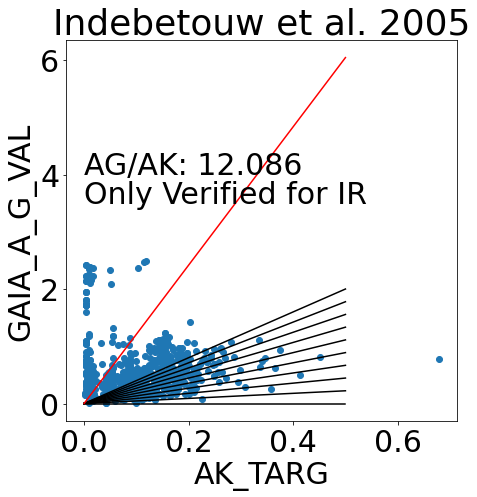

In [55]:
plt.figure(figsize=[7,7])
plt.scatter(gcs['AK_TARG'][exts],gcs['GAIA_A_G_VAL'][exts])
for i in range(len(np.linspace(0.0,4.0,10))):
    plt.plot(np.array([0.,0.5]),np.array([0.,0.5])*np.linspace(0.0,4.0,10)[i],c='k')
    
plt.plot(np.array([0.,0.5]),np.array([0.,0.5])*ind_alak(leff['G']),c='r')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'GAIA_A_G_VAL')
plt.title(r'Indebetouw et al. 2005')
plt.text(0.0,4.0,r'AG/AK: {:.3f}'.format(ind_alak(leff['G'])))
plt.text(0.0,3.5,r'Only Verified for IR')
plt.savefig('indext.pdf',bbox_inches='tight')